## Lab2 Classification

1. 数据探索：理解每个属性的分布，或基本描述统计
2. 数据清洗：未知值处理。提交构建好的新的训练集、测试集文件
3. 模型选择
* 至少选择3种分类算法进行模型对比
* 使用K折交叉检验，K的数值可以自行设置
* 使用多种评价指标
* 保存分类结果
* 模型优化：特征选择、参数调节
4. 结果分析
* 生成模型性能对比表格，绘制性能对比图
* 分析性能优劣原因，案例分析

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.options.display.latex.repr = False

# 数据探索EDA

阅读 `adult.names` 可以得到完整的对于数据集及任务的描述。

数据集共含有14个属性，1个类别属性，48842条记录（随机按照2:1比例分割，分别存于 `adult.data` 和 `adult.test` 中），3620条记录含有缺失值，处理为"?"。

类别揭示实例的收入，共2类（`>50k`,`<=50k`），比例大致为1:3.

14个属性中，离散的属性为

> 2.workclass;  4.education;  6.marital-status;  7.occupation;  8.relationship;  9.race;  10.sex;   14.native-country.

连续的属性为

> 1.age;  3.fnlwgt;  5.education-num;  11.capital-gain;  12.capital-loss;  13.hours-per-week;

大多数的属性都是字面意思。`fnlwgt` 解释为一种权重值，某些人口统计学特征相近的记录有相近的`fnlwgt`，但是此规律仅在同一州内生效。

## 读取数据

In [2]:
columns = ['age','workClass','fnlwgt','education','educationNum','martialStatus','occupation','relationship','race','sex','capitalGain','capitalLoss','hoursPerWeek','nativeCountry','income']
train = pd.read_csv('./data/adult.data',header=None,names=columns) # 源数据没有字段行
test = pd.read_csv('./data/adult.test',header=None,names=columns,skiprows=1) # 源数据第一行不是记录
data = pd.concat([train,test])
data.tail(3)

,age,workClass,fnlwgt,education,educationNum,martialStatus,occupation,relationship,race,sex,capitalGain,capitalLoss,hoursPerWeek,nativeCountry,income
16278,38,Private,374983,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States,<=50K.
16279,44,Private,83891,Bachelors,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455,0,40,United-States,<=50K.
16280,35,Self-emp-inc,182148,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,60,United-States,>50K.


## 描述性统计

In [3]:
display(train.iloc[:,[1,3,5,6,7,8,9,13,14]].describe()) # 离散型数据
display(test.iloc[:,[1,3,5,6,7,8,9,13,14]].describe()) # 离散型数据

,workClass,education,martialStatus,occupation,relationship,race,sex,nativeCountry,income
count,32561,32561,32561,32561,32561,32561,32561,32561,32561
unique,9,16,7,15,6,5,2,42,2
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,<=50K
freq,22696,10501,14976,4140,13193,27816,21790,29170,24720


,workClass,education,martialStatus,occupation,relationship,race,sex,nativeCountry,income
count,16281,16281,16281,16281,16281,16281,16281,16281,16281
unique,9,16,7,15,6,5,2,41,2
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,<=50K.
freq,11210,5283,7403,2032,6523,13946,10860,14662,12435


**注意：离散属性的unique值包含了"?"，缺失值**

**要点1：test数据集中，两种标签分别比train多了句号**

> 下一步处理方案： $>50K. \rightarrow >50K; \ <=50K. \rightarrow <=50K$ 

In [4]:
display(train.iloc[:,[0,2,4,10,11,12]].describe()) #连续型数据
display(test.iloc[:,[0,2,4,10,11,12]].describe()) #连续型数据

,age,fnlwgt,educationNum,capitalGain,capitalLoss,hoursPerWeek
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


,age,fnlwgt,educationNum,capitalGain,capitalLoss,hoursPerWeek
count,16281.000000,1.628100e+04,16281.000000,16281.000000,16281.000000,16281.000000
mean,38.767459,1.894357e+05,10.072907,1081.905104,87.899269,40.392236
std,13.849187,1.057149e+05,2.567545,7583.935968,403.105286,12.479332
min,17.000000,1.349200e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.167360e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.778310e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.383840e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,3770.000000,99.000000


In [5]:
train[train.capitalGain != 0].income.describe()

count      2712
unique        2
top        >50K
freq       1677
Name: income, dtype: object

In [6]:
train[train.capitalLoss != 0].income.describe()

count      1519
unique        2
top        >50K
freq        773
Name: income, dtype: object

**要点2：`capitalGain`、`capitalLoss`超过75%的数据同为0. 抽取非0数据后，各自类别分布与整体不同，说明这个属性对收入分类有一定贡献。**

> 下一步处理：但是为0值的样本较多，可以考虑较少类别的离散化。

## 个别属性理解

In [7]:
data.groupby(by=['fnlwgt']).count().iloc[:,0].sort_values(ascending=False).max()

21

(0.0, 700000.0)

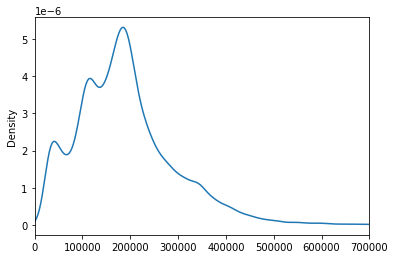

In [8]:
ax = data.fnlwgt.plot.kde()
ax.set_xlim([0,700000])

**要点3：很多网上的分析把fnlwgt解读为id序号，实际上并不是（因为这里可以看到不唯一）。fnlwgt值有一定的分布规律。但是考虑数据集的解读，fnlwgt和部分人口统计学特征有重复表达，所以可以考虑去除该属性或者与某些属性进行综合。**

## 缺失值探索

In [9]:
train.replace(' ?',np.nan).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   age            32561 non-null  int64 
 1   workClass      30725 non-null  object
 2   fnlwgt         32561 non-null  int64 
 3   education      32561 non-null  object
 4   educationNum   32561 non-null  int64 
 5   martialStatus  32561 non-null  object
 6   occupation     30718 non-null  object
 7   relationship   32561 non-null  object
 8   race           32561 non-null  object
 9   sex            32561 non-null  object
 10  capitalGain    32561 non-null  int64 
 11  capitalLoss    32561 non-null  int64 
 12  hoursPerWeek   32561 non-null  int64 
 13  nativeCountry  31978 non-null  object
 14  income         32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


**要点4： 出现缺失值的字段有 `workClass`, `occupation`, `nativeCountry`。**

> 下一步处理：这三个变量都是离散型变量，可以考虑使用众数替换的方法填充缺失值。也可以先删除。

In [10]:
train[(train.workClass==' ?') | (train.occupation==' ?') | (train.nativeCountry==' ?')].income.describe()

count       2399
unique         2
top        <=50K
freq        2066
Name: income, dtype: object

In [11]:
test[(test.workClass==' ?') | (test.occupation==' ?') | (test.nativeCountry==' ?')].income.describe()

count        1221
unique          2
top        <=50K.
freq         1075
Name: income, dtype: object

全部删除，会导致训练集样本减少11.12%，但是相比于给每个属性带来一定的不准确的众数填充，建立baseline时最好还是删除这些含缺失属性的记录为好。

## 重复值探索

In [12]:
data.drop_duplicates(subset=['education','educationNum']).iloc[:,3:5].sort_values(by='educationNum').values

array([[' Preschool', 1],
       [' 1st-4th', 2],
       [' 5th-6th', 3],
       [' 7th-8th', 4],
       [' 9th', 5],
       [' 10th', 6],
       [' 11th', 7],
       [' 12th', 8],
       [' HS-grad', 9],
       [' Some-college', 10],
       [' Assoc-voc', 11],
       [' Assoc-acdm', 12],
       [' Bachelors', 13],
       [' Masters', 14],
       [' Prof-school', 15],
       [' Doctorate', 16]], dtype=object)

**要点5：整个数据集上， `education` 字段和 `educationNum` 字段都是一一对应的，只有16种组合，出现属性冗余现象。**

# 数据处理DP

数据处理部分主要分以下几个任务：
* 错误值修正（1）
* 重复值处理（5）
* 缺失值处理（4）

余下的属性离散化（2）、不明属性处理（3）可以留到模型部分，根据表现适当处理。

## 错误值修正

In [13]:
test['income'] = test['income'].apply(lambda x : x.replace('.',''))

## 重复值处理

直接删除`education`列


In [14]:
train = train.drop(['education'],axis=1)
test = test.drop(['education'],axis=1)

## 缺失值处理

本例的缺失值都来自于离散属性，可以采用众数填充也可以采用删除的方式，为提升baseline可靠性，这里采用删除含缺失值记录的方式。

数据中缺失值以` ?`代替，可以考虑替换为`NaN`后批量删除

In [15]:
train = train.replace(' ?',np.nan)
test = test.replace(' ?',np.nan)

In [16]:
train = train.dropna(axis=0,how='any')
test = test.dropna(axis=0,how='any')

## 数据保存

In [17]:
train.to_csv('./data/adult.proc.data',index=False)
test.to_csv('./data/adult.proc.test',index=False)

# 分类模型Models

### 准备：读取并分割数据集

在上一节已经处理好了数据集，由于所给训练集和测试集数量都很大，且样本类别没有出现极度不均衡的现象，所以可以从训练数据中分割出训练集和验证集，用于模型训练和评估便于优化，而原测试集可以用于最终的表现评价。

因为训练集数量很大，所以可以采用K折交叉验证的方式进行模型训练。基本思路就是将样本分割为$k$份，选取$k-1$份为训练集，$1$份为验证集进行交叉模型训练。

In [18]:
train = pd.read_csv('./data/adult.proc.data')
test = pd.read_csv('./data/adult.proc.test')
x_train = train.iloc[:,:-1]
y_train = train.iloc[:,-1:]
x_test = test.iloc[:,:-1]
y_test = test.iloc[:,-1:]

In [19]:
from sklearn.model_selection import StratifiedKFold

N = 5 # 5折交叉验证
skf = StratifiedKFold(n_splits=N,random_state=101,shuffle=True)

相比于使用`KFold()`，使用`StratifiedKFold()`可以保证每次分割样本的类别分布与整体一致。

## 决策树DT

### Baseline

根据模型特点，进行一点额外的数据处理。`sklearn`的决策树不能接收字符型变量输入，所以需要进行转化。这里采用整数编码的方法。

In [20]:
from sklearn.preprocessing import LabelEncoder

strFields = ['workClass','martialStatus','occupation','relationship','race','sex','nativeCountry']
for field in strFields:
    le = LabelEncoder()
    le = le.fit(np.unique(x_train[field].values))
    train_temp = le.transform(x_train[field].values)
    test_temp = le.transform(x_test[field].values)
    x_train[field] = pd.DataFrame(train_temp,columns=[field])
    x_test[field] = pd.DataFrame(test_temp,columns=[field])

In [21]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(criterion='entropy')
clf.fit(x_train,y_train)

DecisionTreeClassifier(criterion='entropy')

In [22]:
clf.score(x_train,y_train)

0.9999668456998873

In [23]:
clf.score(x_test,y_test)

0.8097609561752988

In [24]:
y = clf.predict(x_test)

In [25]:
pd.DataFrame(y,columns=['income']).groupby(by=['income']).size()

income
 <=50K    11293
 >50K      3767
dtype: int64

基本的交叉熵决策树预测模型可以达到0.81的准确率，这一数值接近`<=50k`的占比75%，查看分类结果发现预测比例较为正常。结合训练集接近1.00的得分可以判断出baseline出现了过拟合的情况，后续可展开优化。

### 优化：剪枝

决策树对训练集过拟合的情况很有可能是决策树深度过深，一般而言，决策树层数较少时会出现欠拟合现象，而层数过多时会出现过拟合现象。

In [26]:
clf.tree_.max_depth

52

我们一共有13个属性，32561个样本（$2^{15}=32768$），但是决策树深度来到了51层，可能对连续属性或多值离散属性进行了过多的分化。

面对决策树过拟合严重的问题，可以采用剪枝的方法，在sklearn中可以通过限定`max_depth`来进行剪枝。下面结合分层KFold测试不同深度下决策树的表现。

In [27]:
train_score = []; val_score = []
for i in range(1,51):
    clf = tree.DecisionTreeClassifier(criterion='entropy',max_depth=i)
    ts = 0; vs = 0
    for train_idx,val_idx in skf.split(x_train.values, y_train.values):
        clf.fit(x_train.values[train_idx],y_train.values[train_idx])
        ts += clf.score(x_train.values[train_idx],y_train.values[train_idx])
        vs += clf.score(x_train.values[val_idx],y_train.values[val_idx])
    train_score.append(ts/N) #取每折结果的均值作为该参数下模型表现
    val_score.append(vs/N)

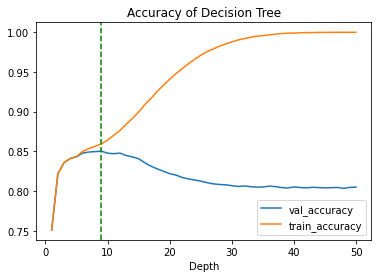

In [28]:
plt.figure()
plt.title('Accuracy of Decision Tree')
plt.plot(range(1,51),val_score,label='val_accuracy')
plt.plot(range(1,51),train_score,label='train_accuracy')
plt.axvline(x=9 , color='green' , linestyle='--')
plt.xlabel('Depth')
plt.legend()

In [29]:
val_score[7:12]

[0.8496123223244745,
 0.850242323278555,
 0.8476229049247707,
 0.8470592829183083,
 0.8477555693904568]

观察图形可知，深度大于9时，验证集准确率达最大值0.850，随后开始下降，所以9附近应该是最佳深度，增加深度会导致模型过拟合。样本总量在32561，处于$2^{14}$和$2^{15}$之间，所以这个深度也是较为合适的。

In [30]:
clf = tree.DecisionTreeClassifier(criterion='entropy',max_depth=9)
clf.fit(x_train,y_train)
clf.score(x_train,y_train)

0.8586963729195677

In [31]:
clf.score(x_test,y_test)

0.849933598937583

### 优化：集成学习

也可以采用集成学习的方法，将决策树桩（每颗决策树深度均为1）作为基分类器，训练多个弱分类器决策树桩，再使用加性模型得到强学习器。

In [32]:
from sklearn.ensemble import AdaBoostClassifier

train_score = []; val_score = []
clf = AdaBoostClassifier(base_estimator=tree.DecisionTreeClassifier(criterion='entropy',max_depth=1), n_estimators=200, random_state=0)
ts = 0; vs = 0
for train_idx,val_idx in skf.split(x_train.values, y_train.values):
    clf.fit(x_train.values[train_idx],y_train.values[train_idx].ravel())
    ts += clf.score(x_train.values[train_idx],y_train.values[train_idx].ravel())
    vs += clf.score(x_train.values[val_idx],y_train.values[val_idx].ravel())

In [33]:
print('Train Score: %.5f' % float(ts/N))
print('Val Score: %.5f' % float(vs/N))

Train Score: 0.86655
Val Score: 0.86543


In [34]:
clf.score(x_test,y_test)

0.8634794156706508

设定基分类器数量上限为200的情况下，训练集、验证集准确率超过了86.5%。验证集准确率则在86.3%。